In [1]:
import datetime
from time import process_time

import spacy
from random import sample
import stanza

from textblob import TextBlob
import textblob.sentiments as tb
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.collocations import *
from nltk.metrics import BigramAssocMeasures

import pandas as pd

from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

**Setup:**

In [2]:
sources = ['nytimes', 'CNN', 'bbcworld', 'theeconomist', 'reuters', 'WSJ', 'TIME', 'ABC', 'washingtonpost', 'AP']

In [3]:
#to get a string back to a datetime object
to_dt = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [4]:
#style:
sns.set_style('darkgrid')

#context:
sns.set_context('notebook')

In [2]:
ORDER = ['nytimes', 'CNN', 'bbcworld', 'theeconomist', 'reuters', 'WSJ', 'TIME', 'ABC', 'washingtonpost', 'AP']
PAL = sns.husl_palette(10, l = 0.6, s = 0.6, h = 0.7)

**Distribution of Polarities:**

In [23]:
dt = pd.read_csv('DATA/' + sources[0] + '_FINAL.csv', index_col = 'ID')

for x in sources[1 : ]:
    dt = dt.append(pd.read_csv('DATA/' + x + '_FINAL.csv', index_col = 'ID'))
    
dt['User'] = dt['User'].str.lstrip('@').replace({'BBCWorld' : 'bbcworld', 'Reuters' : 'reuters', 'TheEconomist' : 'theeconomist'})

In [24]:
dt.head()

,User,Source_Name,Tweet_Text,Date_Time,Sentiment,Named_Entities
ID,,,,,,
1234991999750565888,nytimes,The New York Times,"Polls have now closed in Vermont, Virginia and...",2020-03-04 00:00:12,0.018,"[('Vermont', 1, 'GPE'), ('Virginia', 1, 'GPE')..."
1234993730874011649,nytimes,The New York Times,Breaking News: Joe Biden won Virginia and Bern...,2020-03-04 00:07:05,0.323,"[('Joe Biden', 1, 'PERSON'), ('Virginia', 1, '..."
1234996189403041795,nytimes,The New York Times,Our reporters are providing real-time updates ...,2020-03-04 00:16:51,0.417,"[('Super Tuesday', 1, 'DATE')]"
1234997580829872128,nytimes,The New York Times,As we wait for more polls to close in Super Tu...,2020-03-04 00:22:23,0.411,"[('Tuesday', 1, 'DATE'), ('Democratic', 1, 'NO..."
1234999525594423296,nytimes,The New York Times,Polls have now closed in North Carolina. Follo...,2020-03-04 00:30:06,0.123,"[('North Carolina', 1, 'GPE'), ('Tuesday', 1, ..."


In [25]:
print(len(dt))
dt['User'].value_counts()

39791


reuters           12030
ABC                4649
CNN                4615
washingtonpost     4130
nytimes            3207
theeconomist       3179
WSJ                2633
TIME               2398
AP                 1764
bbcworld           1186
Name: User, dtype: int64

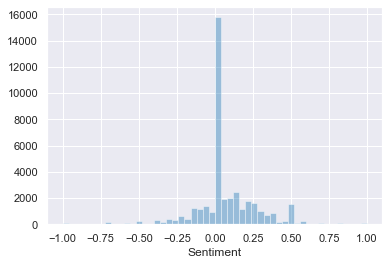

In [9]:
#overall sentiment distribution
#less interesting because of how Reuters dominates the data set
sns.distplot(dt['Sentiment'], kde = False)

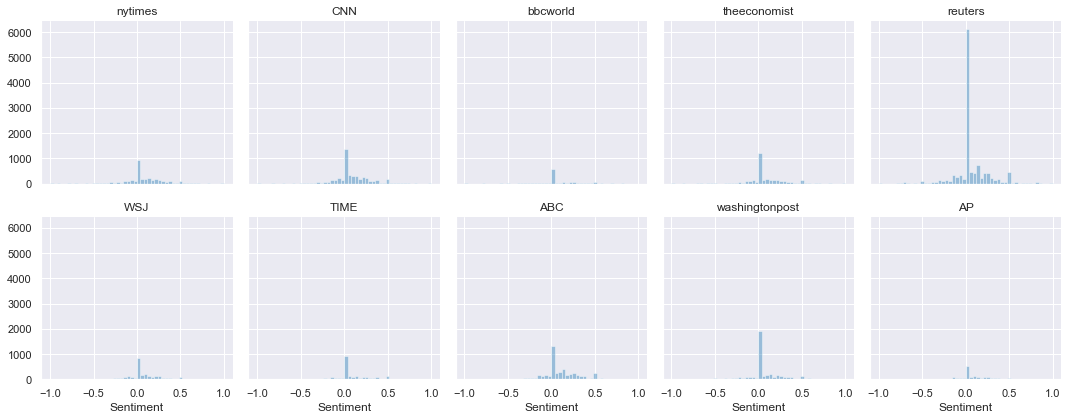

In [12]:
#hard to see anything interesting, large spikes at polarity of 0...
#also, Reuters dominates again
g = sns.FacetGrid(dt, col = 'User', col_wrap = 5, col_order = ORDER, \
                  palette = PAL)
g.map(sns.distplot, 'Sentiment', kde = False).set_titles('{col_name}')

In [16]:
g.savefig('SA_dist_w_zero.png', dpi = 400)

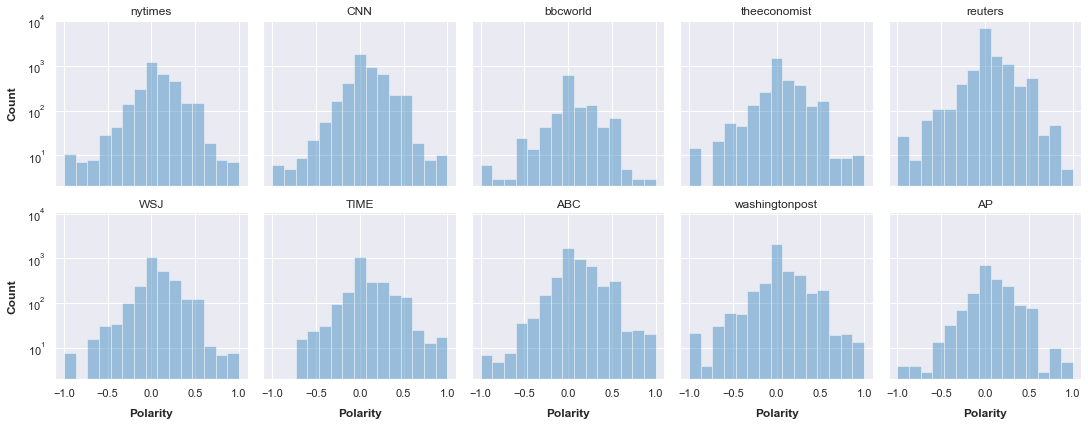

In [33]:
#using a logscale so that more of the distribution is visible
f = sns.FacetGrid(dt, col = 'User', col_wrap = 5, col_order = ORDER, palette = PAL)
f.map(sns.distplot, 'Sentiment', bins = 15, kde = False, hist_kws = {'log' : True}).set_titles('{col_name}')

f.set_xlabels('Polarity', fontsize = 12, labelpad = 10, **{'fontweight' : 'semibold'})
f.set_ylabels('Count', fontsize = 12, labelpad = 10, **{'fontweight' : 'semibold'})

In [34]:
f.savefig('SA_dist_w_zero_logscale', dpi = 400)

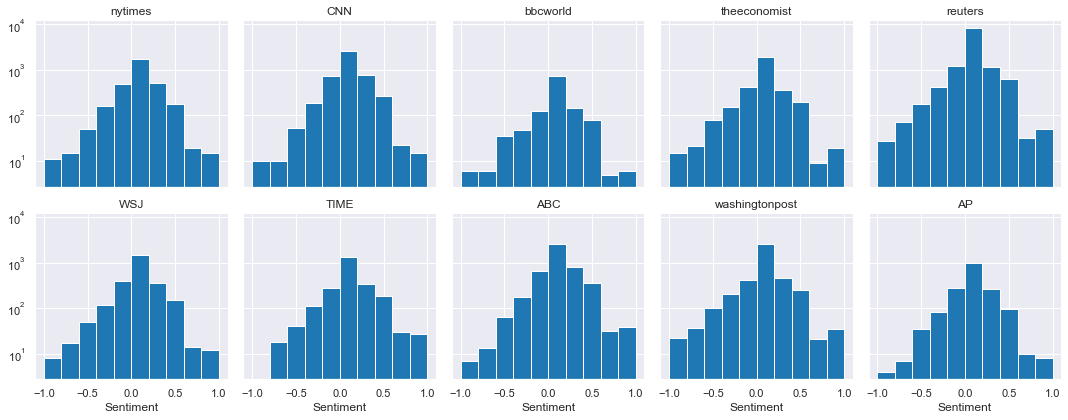

In [20]:
#for reference... using matplotlib's histogram
h = sns.FacetGrid(dt, col = 'User', col_wrap = 5, \
                  palette = sns.husl_palette(15, l = 0.6, s = 0.6, h = 0.7))
h.map(plt.hist, 'Sentiment', log = True).set_titles('{col_name}')

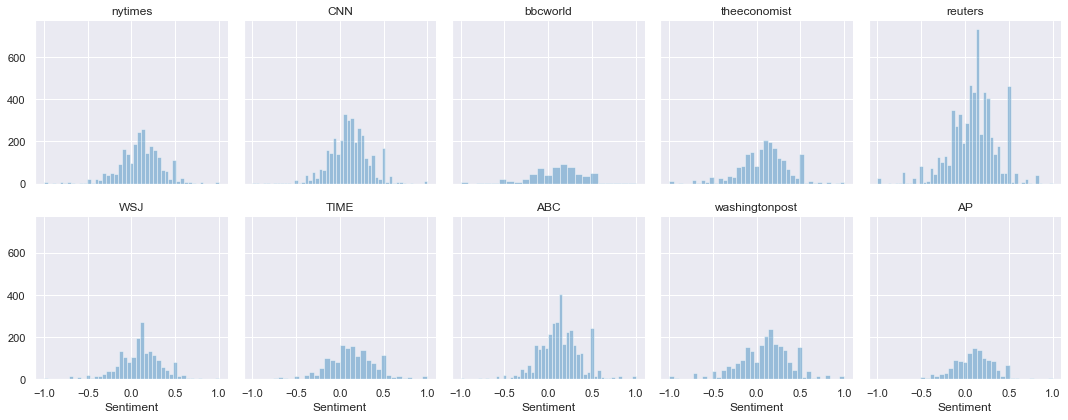

In [18]:
#pulling out the 0 polarity tweets and looking at resulting distribution
alt = dt[dt['Sentiment'] != 0]

g = sns.FacetGrid(alt, col = 'User', col_wrap = 5, col_order = ORDER, \
                  palette = PAL)
g.map(sns.distplot, 'Sentiment', kde = False).set_titles('{col_name}')

In [19]:
g.savefig('SA_dist_w_out_zero.png', dpi = 400)

In [69]:
#summarizing in a table
w_zero = dt.groupby('User')
w_out_zero = alt.groupby('User')

sent_summary = pd.concat([w_zero.mean(), w_zero.median(), w_out_zero.mean(), w_out_zero.median()], axis = 1)
sent_summary.columns = ['Mean_Sent_w_Zero', 'Median_Sent_w_Zero', 'Mean_Sent_w_out_Zero', 'Median_Sent_w_out_Zero']      
sent_summary.loc['Overall'] = [dt['Sentiment'].mean(), dt['Sentiment'].median(), alt['Sentiment'].mean(), dt['Sentiment'].median()]
for col in sent_summary.columns:
    sent_summary[col] = sent_summary[col].apply(lambda x: round(x, 3))  

sent_summary

,Mean_Sent_w_Zero,Median_Sent_w_Zero,Mean_Sent_w_out_Zero,Median_Sent_w_out_Zero
User,,,,
ABC,0.102,0.050,0.134,0.136
AP,0.072,0.012,0.098,0.106
CNN,0.082,0.034,0.109,0.106
TIME,0.085,0.000,0.130,0.129
WSJ,0.067,0.000,0.093,0.100
bbcworld,0.050,0.000,0.094,0.136
nytimes,0.073,0.030,0.098,0.107
reuters,0.048,0.000,0.094,0.114
theeconomist,0.054,0.000,0.084,0.100


In [168]:
sent_summary.to_csv('SA_summary.csv')

**Polarity Over Time:**

In [20]:
#downsampling to get nicer lineplots (using mean as summarizer)
#also try without downsampling!

#using 3 day bins
dt2 = pd.read_csv('DATA/' + sources[0] + '_FINAL.csv', index_col = 'ID')
dt2['Date_Time'] = dt2['Date_Time'].apply(to_dt)
dt2.set_index('Date_Time', inplace = True)
dt2 = dt2.resample('3D').mean()
dt2['User'] = [sources[0]] * len(dt2)

for x in sources[1 : ]:
    to_add = pd.read_csv('DATA/' + x + '_FINAL.csv', index_col = 'ID')
    to_add['Date_Time'] = to_add['Date_Time'].apply(to_dt)
    to_add.set_index('Date_Time', inplace = True)
    to_add = to_add.resample('3D').mean()
    to_add['User'] = [x] * len(to_add)
    
    dt2 = dt2.append(to_add)
    
dt2['User'] = dt2['User'].str.lstrip('@').replace({'BBCWorld' : 'bbcworld', 'Reuters' : 'reuters', 'TheEconomist' : 'theeconomist'})
dt2['User'].value_counts()

washingtonpost    10
nytimes           10
theeconomist      10
bbcworld          10
CNN               10
TIME              10
WSJ               10
ABC               10
reuters           10
AP                10
Name: User, dtype: int64

In [21]:
dt2.head()

,Sentiment,User
Date_Time,,
2020-03-04,0.078171,nytimes
2020-03-07,0.076752,nytimes
2020-03-10,0.086594,nytimes
2020-03-13,0.078009,nytimes
2020-03-16,0.063302,nytimes


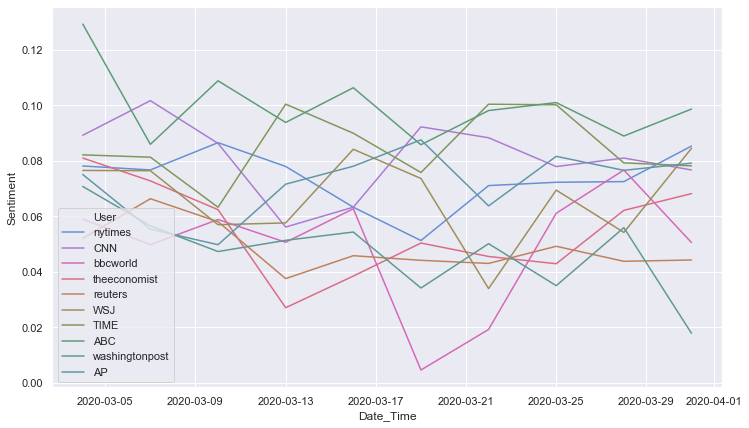

In [8]:
#too messy...
plt.figure(figsize = (12, 7))
sns.lineplot(x = dt2.index, y = dt2['Sentiment'], hue = dt2['User'], \
             palette = PAL, hue_order = ORDER)

In [22]:
#creating the unweighted average line for each plot
alt2 = dt2.copy()
alt2['DT'] = dt2.index
alt2['Type'] = [0] * len(alt2)

om = alt2.groupby('DT').mean()
om['DT'] = om.index
om['Type'] = [1] * 10
om.rename(index = {'DT' : 'Date_Time'}, inplace = True)

for u in alt2['User'].unique():
    cop = om.copy()
    cop['User'] = [u] * 10
    alt2 = alt2.append(cop)
    
alt2

/Users/emiliolr/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,DT,Sentiment,Type,User
2020-03-04,2020-03-04,0.078171,0,nytimes
2020-03-07,2020-03-07,0.076752,0,nytimes
2020-03-10,2020-03-10,0.086594,0,nytimes
2020-03-13,2020-03-13,0.078009,0,nytimes
2020-03-16,2020-03-16,0.063302,0,nytimes
2020-03-19,2020-03-19,0.051289,0,nytimes
2020-03-22,2020-03-22,0.071108,0,nytimes
2020-03-25,2020-03-25,0.072298,0,nytimes
2020-03-28,2020-03-28,0.072540,0,nytimes
2020-03-31,2020-03-31,0.085369,0,nytimes


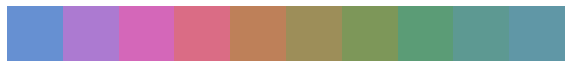

In [4]:
#pulling out specific colors out of the palette
c = [tuple(p) for p in PAL]
sns.palplot(c)
plt.axis('off')
line_pal = sns.color_palette([c[0], c[3]])

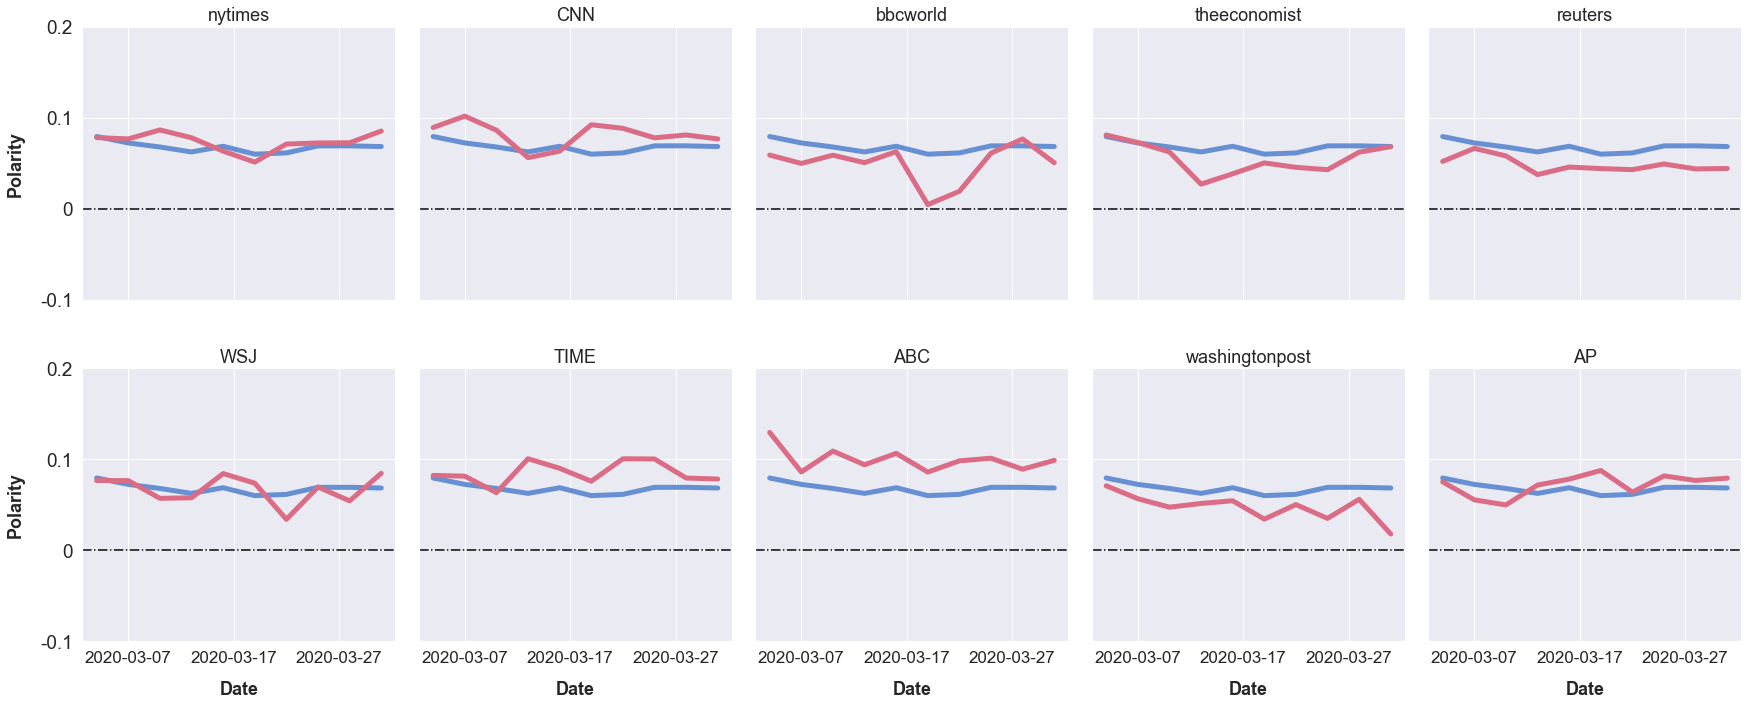

In [45]:
#SA over time for each source
with sns.plotting_context('notebook', font_scale = 1.5):
    g = sns.relplot(data = alt2, x = 'DT', y = 'Sentiment', col = 'User', col_wrap = 5, kind = 'line', lw = 5, \
                    hue = 'Type', hue_order = [1, 0], palette = line_pal, \
                    col_order = ORDER, legend = False).set_titles('{col_name}', fontsize = 22).set(ylim = (-0.1, 0.2), \
                    xticks = ['2020-03-07', '2020-03-17', '2020-03-27'], yticks = [-0.1, 0, 0.1, 0.2])

    g.fig.subplots_adjust(wspace = 0.075, hspace = 0.25)
    g.set_ylabels('Polarity', fontsize = 18, labelpad = 15, **{'fontweight' : 'semibold'})
    g.set_xlabels('Date', fontsize = 18, labelpad = 15, **{'fontweight' : 'semibold'})
    
    #adding a zero line and setting tick labels
    for a in g.axes:
        a.axhline(0, ls = '-.', color = 'k')
        a.set_yticklabels([-0.1, 0, 0.1, 0.2], size = 19)
        a.set_xticklabels(['2020-03-07', '2020-03-17', '2020-03-27'], size = 17)

In [46]:
g.savefig('SA_lineplot_finalfig.png', dpi = 400)

**Prevalence of Zero-Polarity Tweets:**

In [6]:
dt3 = pd.read_csv('DATA/' + sources[0] + '_FINAL.csv', index_col = 'ID')

for x in sources[1 : ]:
    dt3 = dt3.append(pd.read_csv('DATA/' + x + '_FINAL.csv', index_col = 'ID'))
    
dt3['User'] = dt3['User'].str.lstrip('@').replace({'BBCWorld' : 'bbcworld', 'Reuters' : 'reuters', 'TheEconomist' : 'theeconomist'})

In [7]:
dt3['User'].value_counts()

reuters           12030
ABC                4649
CNN                4615
washingtonpost     4130
nytimes            3207
theeconomist       3179
WSJ                2633
TIME               2398
AP                 1764
bbcworld           1186
Name: User, dtype: int64

In [8]:
dt3['Zero_Pol'] = dt3['Sentiment'].apply(lambda x: 1 if x == 0 else 0)
dt3['Zero_Pol'].sum()

14482

In [9]:
dt3.head()

,User,Source_Name,Tweet_Text,Date_Time,Sentiment,Named_Entities,Zero_Pol
ID,,,,,,,
1234991999750565888,nytimes,The New York Times,"Polls have now closed in Vermont, Virginia and...",2020-03-04 00:00:12,0.018,"[('Vermont', 1, 'GPE'), ('Virginia', 1, 'GPE')...",0
1234993730874011649,nytimes,The New York Times,Breaking News: Joe Biden won Virginia and Bern...,2020-03-04 00:07:05,0.323,"[('Joe Biden', 1, 'PERSON'), ('Virginia', 1, '...",0
1234996189403041795,nytimes,The New York Times,Our reporters are providing real-time updates ...,2020-03-04 00:16:51,0.417,"[('Super Tuesday', 1, 'DATE')]",0
1234997580829872128,nytimes,The New York Times,As we wait for more polls to close in Super Tu...,2020-03-04 00:22:23,0.411,"[('Tuesday', 1, 'DATE'), ('Democratic', 1, 'NO...",0
1234999525594423296,nytimes,The New York Times,Polls have now closed in North Carolina. Follo...,2020-03-04 00:30:06,0.123,"[('North Carolina', 1, 'GPE'), ('Tuesday', 1, ...",0


In [10]:
zero_pol = dt3.groupby('User')['Zero_Pol'].sum()
props = pd.concat([zero_pol, dt3['User'].value_counts()], axis = 1, sort = True)
props.rename(columns = {'User' : 'Total'}, inplace = True)
props

,Zero_Pol,Total
ABC,1102,4649
AP,470,1764
CNN,1147,4615
TIME,823,2398
WSJ,738,2633
bbcworld,553,1186
nytimes,801,3207
reuters,5857,12030
theeconomist,1152,3179
washingtonpost,1839,4130


In [11]:
for_an = props.reindex(ORDER)

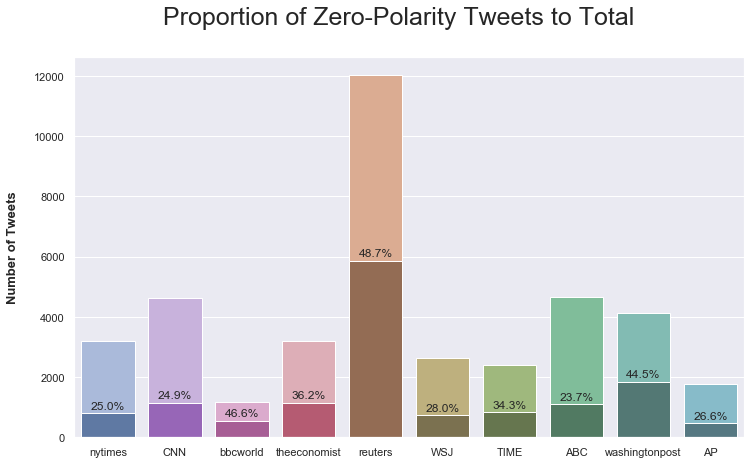

In [15]:
#plot of proportion of zero-pol tweets to total
f, ax = plt.subplots(figsize = (12, 7))

sns.barplot(x = props.index, y = props['Total'], label = 'Total', \
            palette = sns.husl_palette(10, l = 0.75, s = 0.6, h = 0.7), \
            order = ORDER)

splot = sns.barplot(x = props.index, y = props['Zero_Pol'], label = 'Zero Polarity', \
            palette = sns.husl_palette(10, l = 0.5, s = 0.6, h = 0.7), \
            order = ORDER)

plt.ylabel('Number of Tweets', fontsize = 13, labelpad = 15, **{'fontweight' : 'semibold'})
plt.suptitle('Proportion of Zero-Polarity Tweets to Total', fontsize = 25)

an = [round(x * 100, 1) for x  in (for_an['Zero_Pol'] / for_an['Total'])]
# print(an)

ct = 1
for p in splot.patches:
    if ct > 10:
        splot.annotate(str(an[ct - 11]) + '%', (p.get_x() + p.get_width() / 2., p.get_height() - 90), \
                       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    ct += 1

In [40]:
f.savefig('SA_prop_of_zero_polarity_to_total.png', dpi = 400)

In [12]:
#splitting by positive, negative, and neutral now
dt3['Pol'] = dt3['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
dt3.head()

,User,Source_Name,Tweet_Text,Date_Time,Sentiment,Named_Entities,Zero_Pol,Pol
ID,,,,,,,,
1234991999750565888,nytimes,The New York Times,"Polls have now closed in Vermont, Virginia and...",2020-03-04 00:00:12,0.018,"[('Vermont', 1, 'GPE'), ('Virginia', 1, 'GPE')...",0,Positive
1234993730874011649,nytimes,The New York Times,Breaking News: Joe Biden won Virginia and Bern...,2020-03-04 00:07:05,0.323,"[('Joe Biden', 1, 'PERSON'), ('Virginia', 1, '...",0,Positive
1234996189403041795,nytimes,The New York Times,Our reporters are providing real-time updates ...,2020-03-04 00:16:51,0.417,"[('Super Tuesday', 1, 'DATE')]",0,Positive
1234997580829872128,nytimes,The New York Times,As we wait for more polls to close in Super Tu...,2020-03-04 00:22:23,0.411,"[('Tuesday', 1, 'DATE'), ('Democratic', 1, 'NO...",0,Positive
1234999525594423296,nytimes,The New York Times,Polls have now closed in North Carolina. Follo...,2020-03-04 00:30:06,0.123,"[('North Carolina', 1, 'GPE'), ('Tuesday', 1, ...",0,Positive


In [13]:
#getting percentages for each category
bn = pd.DataFrame(columns = ['User', 'Pol', 'Pctg'])

ct = 0
for s in sources:
    a = dt3[dt3['User'] == s]['Pol'].value_counts()
    tot = a.sum()
    sub_ct = 0
    for i in a:
        bn.loc[ct] = [s, a.index[sub_ct], a.iloc[sub_ct] / tot]
        sub_ct += 1
        ct += 1
    
bn['Pctg'] = bn['Pctg'].apply(lambda x: round(x, 3))
bn

,User,Pol,Pctg
0,nytimes,Positive,0.525
1,nytimes,Neutral,0.250
2,nytimes,Negative,0.225
3,CNN,Positive,0.539
4,CNN,Neutral,0.249
5,CNN,Negative,0.213
6,bbcworld,Neutral,0.466
7,bbcworld,Positive,0.347
8,bbcworld,Negative,0.186
9,theeconomist,Positive,0.418


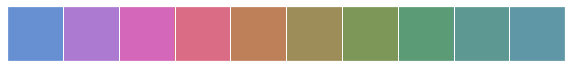

In [17]:
sns.palplot(c)
bp_pal = [c[3], c[7], c[0]]

Text(0.5, 1.0, 'Breakdown of Polarity Scores')

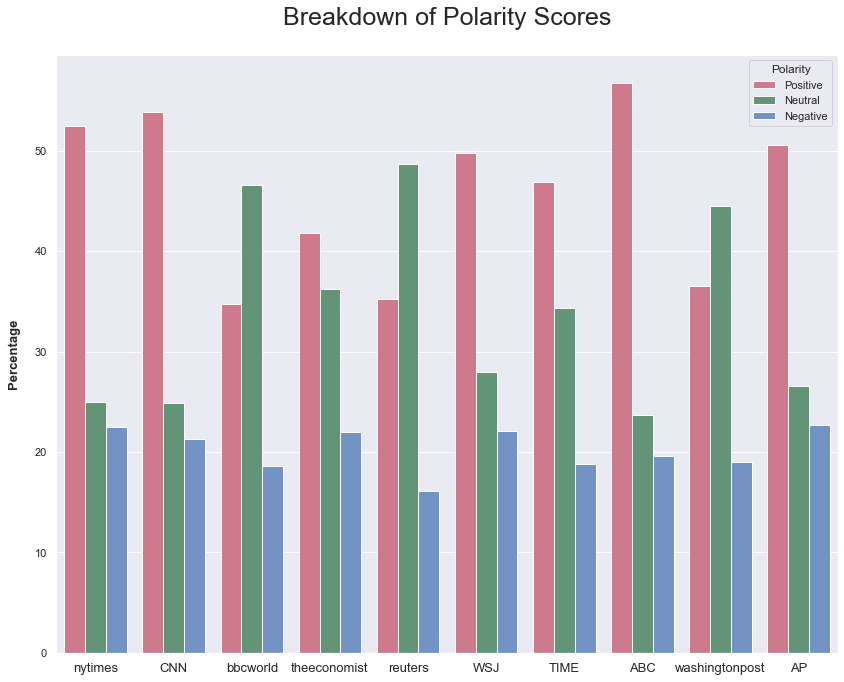

In [18]:
#plotting all three categories
plt.figure(figsize = (14, 11))
bp = sns.barplot(x = bn['User'], y = bn['Pctg'] * 100, hue = bn['Pol'], palette = bp_pal, order = ORDER)
bp.legend().set_title('Polarity')

plt.ylabel('Percentage', fontsize = 13, labelpad = 15, **{'fontweight' : 'semibold'})
plt.xlabel('')
bp.set_xticklabels(ORDER, size = 13)
plt.title('Breakdown of Polarity Scores', fontsize = 25, pad = 30)

In [19]:
bp.get_figure().savefig('polarity_breakdown.png', dpi = 400)

Text(0.5, 1.0, 'Breakdown of Polarity Scores')

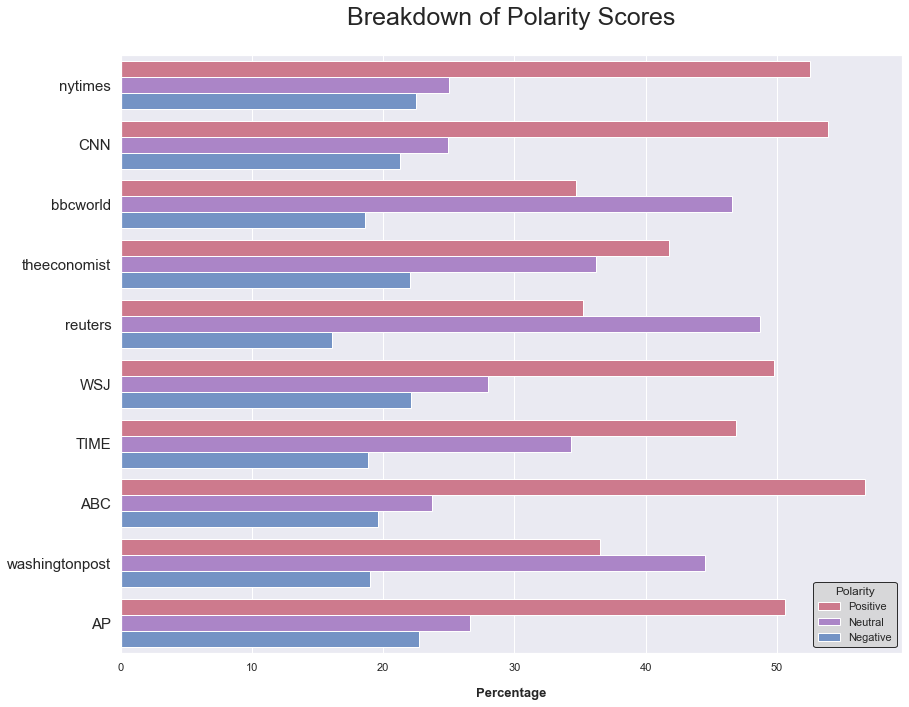

In [28]:
#alternate plot, horizontal
plt.figure(figsize = (14, 11))
bp1 = sns.barplot(x = bn['Pctg'] * 100, y = bn['User'], hue = bn['Pol'], palette = bp_pal, order = ORDER)
plt.legend(edgecolor = 'black', title = 'Polarity', facecolor = 'lightgrey')

plt.xlabel('Percentage', fontsize = 13, labelpad = 15, **{'fontweight' : 'semibold'})
plt.ylabel('')
bp1.set_yticklabels(ORDER, size = 15)
plt.title('Breakdown of Polarity Scores', fontsize = 25, pad = 30)

In [29]:
bp1.get_figure().savefig('polarity_breakdown_ALT.png', dpi = 400)

**Splitting things up (about COVID vs. not about COVID):**

In [47]:
#naive method for checking if a tweet is about COVID
def check_inc(x):
    if ('covid' in x.lower() or 'coronavirus' in x.lower()):
        #is about COVID
        return 1
    #isn't about COVID
    return 0

In [48]:
#splitting into two seperate data sets

#using 3 day bins
dt4 = pd.read_csv('DATA/' + sources[0] + '_FINAL.csv', index_col = 'ID')
dt4['About_COVID'] = dt4['Tweet_Text'].fillna('').apply(check_inc)
dt4['Date_Time'] = dt4['Date_Time'].apply(to_dt)
dt4.set_index('Date_Time', inplace = True)

about = dt4[dt4['About_COVID'] == 1]
about = about.resample('3D').mean()
about['User'] = [sources[0]] * len(about)

not_about = dt4[dt4['About_COVID'] == 0]
not_about = not_about.resample('3D').mean()
not_about['User'] = [sources[0]] * len(not_about)

for x in sources[1 : ]:
    to_add = pd.read_csv('DATA/' + x + '_FINAL.csv', index_col = 'ID')
    to_add['About_COVID'] = to_add['Tweet_Text'].fillna('').apply(check_inc)
    to_add['Date_Time'] = to_add['Date_Time'].apply(to_dt)
    to_add.set_index('Date_Time', inplace = True)

    about1 = to_add[to_add['About_COVID'] == 1]
    about1 = about1.resample('3D').mean()
    about1['User'] = [x] * len(about1)

    not_about1 = to_add[to_add['About_COVID'] == 0]
    not_about1 = not_about1.resample('3D').mean()
    not_about1['User'] = [x] * len(not_about1)
    
    about = about.append(about1)
    not_about = not_about.append(not_about1)
    
about['User'] = about['User'].str.lstrip('@').replace({'BBCWorld' : 'bbcworld', 'Reuters' : 'reuters', 'TheEconomist' : 'theeconomist'})
not_about['User'] = not_about['User'].str.lstrip('@').replace({'BBCWorld' : 'bbcworld', 'Reuters' : 'reuters', 'TheEconomist' : 'theeconomist'})
print(len(about), len(not_about))
not_about['User'].value_counts()

100 100


washingtonpost    10
nytimes           10
theeconomist      10
bbcworld          10
CNN               10
TIME              10
WSJ               10
ABC               10
reuters           10
AP                10
Name: User, dtype: int64

In [49]:
tot = about.append(not_about)
tot['DT'] = tot.index
tot.head()

,Sentiment,About_COVID,User,DT
Date_Time,,,,
2020-03-04,0.036054,1,nytimes,2020-03-04
2020-03-07,0.057948,1,nytimes,2020-03-07
2020-03-10,0.075453,1,nytimes,2020-03-10
2020-03-13,0.077213,1,nytimes,2020-03-13
2020-03-16,0.093194,1,nytimes,2020-03-16


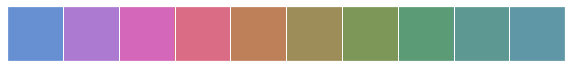

In [50]:
c = [tuple(p) for p in PAL]
sns.palplot(c)
line_palA = sns.color_palette([c[1], c[8]])

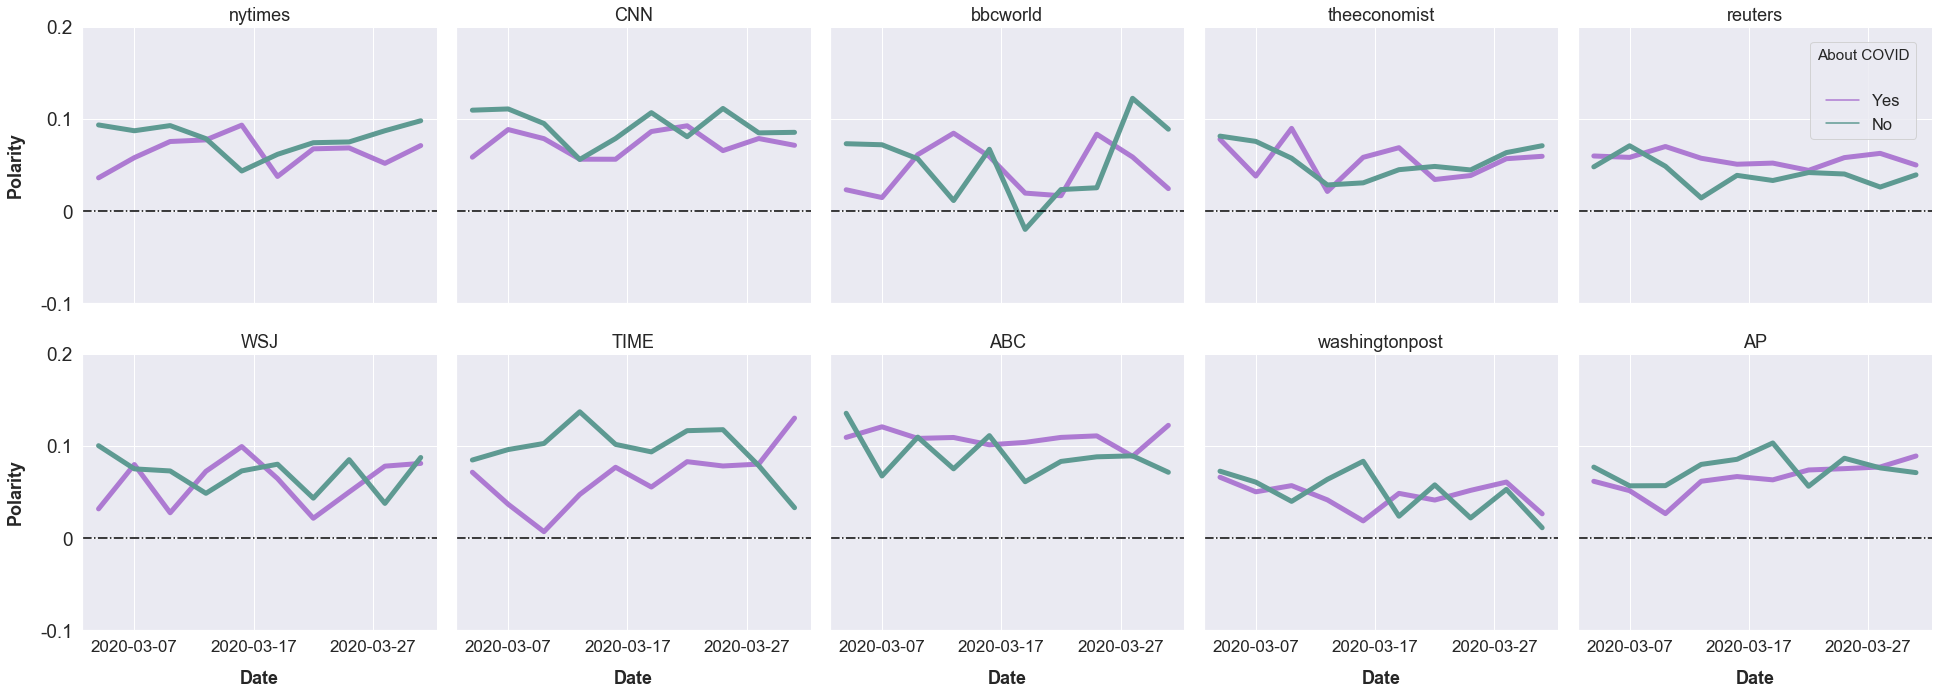

In [66]:
#SA split by COVID/non-COVID tweets
with sns.plotting_context('notebook', font_scale = 1.5):
    e = sns.relplot(data = tot, x = 'DT', y = 'Sentiment', col = 'User', col_wrap = 5, kind = 'line', lw = 5, \
                    hue = 'About_COVID', hue_order = [1, 0], palette = line_palA, \
                    col_order = ORDER).set_titles('{col_name}', fontsize = 22).set(ylim = (-0.1, 0.2), \
                    xticks = ['2020-03-07', '2020-03-17', '2020-03-27'], yticks = [-0.1, 0, 0.1, 0.2])

    e.fig.subplots_adjust(wspace = 0.075, hspace = 0.25)
    e.set_ylabels('Polarity', fontsize = 18, labelpad = 15, **{'fontweight' : 'semibold'})
    e.set_xlabels('Date', fontsize = 18, labelpad = 15, **{'fontweight' : 'semibold'})
    
    #fixing the legend
    e._legend.set_title('About COVID')
    e._legend.set_frame_on(True)
    e._legend.set_bbox_to_anchor((0.98, 0.84))
    new_labels = ['', 'Yes', 'No']
    for t, l in zip(e._legend.texts, new_labels): 
        t.set_text(l)

    #adding a zero line and adjusting tick labels
    for a in e.axes:
        a.axhline(0, ls = '-.', color = 'k')
        a.set_yticklabels([-0.1, 0, 0.1, 0.2], size = 19)
        a.set_xticklabels(['2020-03-07', '2020-03-17', '2020-03-27'], size = 17)
        
    plt.tight_layout()

In [65]:
e.savefig('polarity_lineplot_SPLIT.png', dpi = 400)

**Additional Plots for Paper:**

In [15]:
dt = pd.read_csv('DATA/' + sources[0] + '_FINAL.csv', index_col = 'ID')

for x in sources[1 : ]:
    dt = dt.append(pd.read_csv('DATA/' + x + '_FINAL.csv', index_col = 'ID'))
    
dt['User'] = dt['User'].str.lstrip('@').replace({'BBCWorld' : 'bbcworld', 'Reuters' : 'reuters', 'TheEconomist' : 'theeconomist'})
dt['Type'] = dt['Tweet_Text'].fillna('').apply(check_inc)
dt['Zero_Pol'] = dt['Sentiment'].apply(lambda x: 1 if x == 0 else 0) 
dt['Type'].value_counts()

0    22178
1    17613
Name: Type, dtype: int64

In [16]:
dt.head()

,User,Source_Name,Tweet_Text,Date_Time,Sentiment,Named_Entities,Type,Zero_Pol
ID,,,,,,,,
1234991999750565888,nytimes,The New York Times,"Polls have now closed in Vermont, Virginia and...",2020-03-04 00:00:12,0.018,"[('Vermont', 1, 'GPE'), ('Virginia', 1, 'GPE')...",0,0
1234993730874011649,nytimes,The New York Times,Breaking News: Joe Biden won Virginia and Bern...,2020-03-04 00:07:05,0.323,"[('Joe Biden', 1, 'PERSON'), ('Virginia', 1, '...",0,0
1234996189403041795,nytimes,The New York Times,Our reporters are providing real-time updates ...,2020-03-04 00:16:51,0.417,"[('Super Tuesday', 1, 'DATE')]",0,0
1234997580829872128,nytimes,The New York Times,As we wait for more polls to close in Super Tu...,2020-03-04 00:22:23,0.411,"[('Tuesday', 1, 'DATE'), ('Democratic', 1, 'NO...",0,0
1234999525594423296,nytimes,The New York Times,Polls have now closed in North Carolina. Follo...,2020-03-04 00:30:06,0.123,"[('North Carolina', 1, 'GPE'), ('Tuesday', 1, ...",0,0


In [17]:
for_dist = dt.copy()
for_dist['Type'] = for_dist['Type'].replace({0 : 'Not COVID', 1 : 'COVID'})

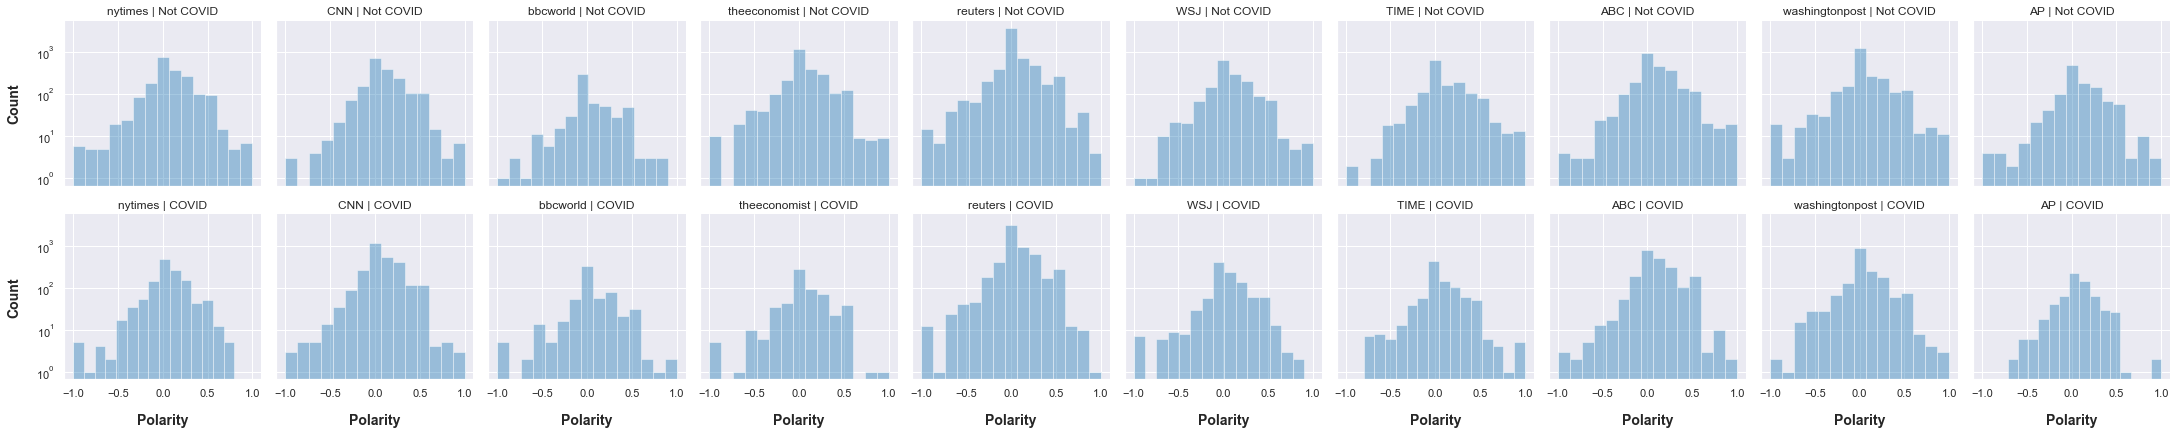

In [20]:
#distplots for COVID/non-COVID tweets
fff = sns.FacetGrid(for_dist, col = 'User', row = 'Type', col_order = ORDER, palette = PAL)
fff.map(sns.distplot, 'Sentiment', bins = 15, kde = False, hist_kws = {'log' : True}).set_titles('{col_name} | {row_name}')

fff.set_xlabels('Polarity', fontsize = 14, labelpad = 15, **{'fontweight' : 'semibold'})
fff.set_ylabels('Count', fontsize = 14, labelpad = 15, **{'fontweight' : 'semibold'})
fff.fig.subplots_adjust(wspace = 0.075)

In [22]:
fff.savefig('polarity_distplot_SPLIT.png', dpi = 400)

In [119]:
#building series split on about COVID vs. not
zero_pol_about = dt[dt['Type'] == 1].groupby('User')['Zero_Pol'].sum()
zero_pol_not = dt[dt['Type'] == 0].groupby('User')['Zero_Pol'].sum()

props_about = pd.concat([zero_pol_about, dt[dt['Type'] == 1]['User'].value_counts()], axis = 1, sort = True)
props_about.rename(columns = {'User' : 'Total'}, inplace = True)
props_about = props_about.reindex(ORDER)

props_not = pd.concat([zero_pol_not, dt[dt['Type'] == 0]['User'].value_counts()], axis = 1, sort = True)
props_not.rename(columns = {'User' : 'Total'}, inplace = True)
props_not = props_not.reindex(ORDER)

props_about['Zero_Pol'].sum() + props_not['Zero_Pol'].sum()

14482

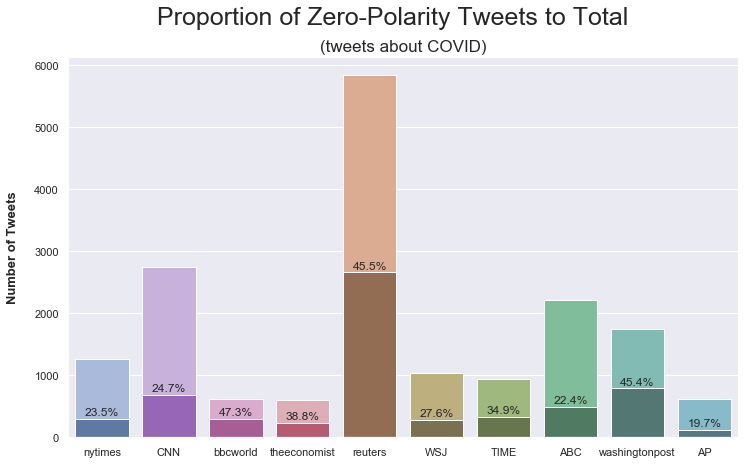

In [133]:
#stacked barplot, COVID tweets
f, ax = plt.subplots(figsize = (12, 7))

sns.barplot(x = props_about.index, y = props_about['Total'], label = 'Total', \
            palette = sns.husl_palette(10, l = 0.75, s = 0.6, h = 0.7), \
            order = ORDER)

splotA = sns.barplot(x = props_about.index, y = props_about['Zero_Pol'], label = 'Zero Polarity', \
            palette = sns.husl_palette(10, l = 0.5, s = 0.6, h = 0.7), \
            order = ORDER)

plt.ylabel('Number of Tweets', fontsize = 13, labelpad = 15, **{'fontweight' : 'semibold'})
plt.suptitle('Proportion of Zero-Polarity Tweets to Total', fontsize = 25)
plt.title('(tweets about COVID)', fontsize = 17)

an = [round(x * 100, 1) for x  in (props_about['Zero_Pol'] / props_about['Total'])]

ct = 1
for p in splotA.patches:
    if ct > 10:
        splotA.annotate(str(an[ct - 11]) + '%', (p.get_x() + p.get_width() / 2., p.get_height() - 55), \
                       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    ct += 1

In [137]:
splotA.get_figure().savefig('stacked_barplot_about_COVID.png', dpi = 400)

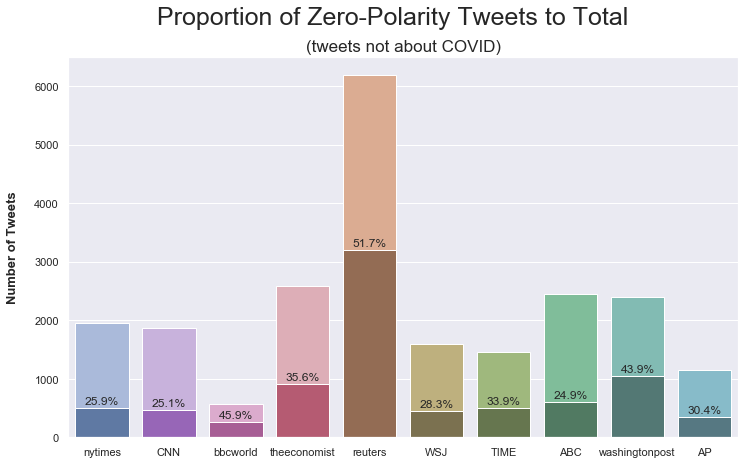

In [135]:
#stacked barplot, non-COVID tweets
f, ax = plt.subplots(figsize = (12, 7))

sns.barplot(x = props_not.index, y = props_not['Total'], label = 'Total', \
            palette = sns.husl_palette(10, l = 0.75, s = 0.6, h = 0.7), \
            order = ORDER)

splotB = sns.barplot(x = props_not.index, y = props_not['Zero_Pol'], label = 'Zero Polarity', \
            palette = sns.husl_palette(10, l = 0.5, s = 0.6, h = 0.7), \
            order = ORDER)

plt.ylabel('Number of Tweets', fontsize = 13, labelpad = 15, **{'fontweight' : 'semibold'})
plt.suptitle('Proportion of Zero-Polarity Tweets to Total', fontsize = 25)
plt.title('(tweets not about COVID)', fontsize = 17)

an = [round(x * 100, 1) for x  in (props_not['Zero_Pol'] / props_not['Total'])]
# print(an)

ct = 1
for p in splotB.patches:
    if ct > 10:
        splotB.annotate(str(an[ct - 11]) + '%', (p.get_x() + p.get_width() / 2., p.get_height() - 55), \
                       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    ct += 1

In [138]:
splotB.get_figure().savefig('stacked_barplot_not_about_COVID.png', dpi = 400)